In [16]:
%cd /data/gunsbrother/prjs/ltvu/ours
import json
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from ltvu.models.egovlpv1.model import TextOnlyFrozenInTime
from ltvu.data_loader.egonlq import EgoNLQDataset

device = 'cpu'
# lm = SentenceTransformer('all-mpnet-base-v2', device='cuda')
lm = TextOnlyFrozenInTime(device=device)
tokenizer = lm.tokenizer
ds = EgoNLQDataset(tokenizer=tokenizer, split='val')
lm.eval()
len(ds)

/data/gunsbrother/prjs/ltvu/ours


4539

cc2d7790-67f7-4e52-9fa9-33121c9431a2
data/Ego4D-processed/captions/VideoRecap/caption_2s_uniner_outputs/cc2d7790-67f7-4e52-9fa9-33121c9431a2.json
294
IoU: 0.028, IoGT: 1.000
61.0s / 480.04s = 12.71%


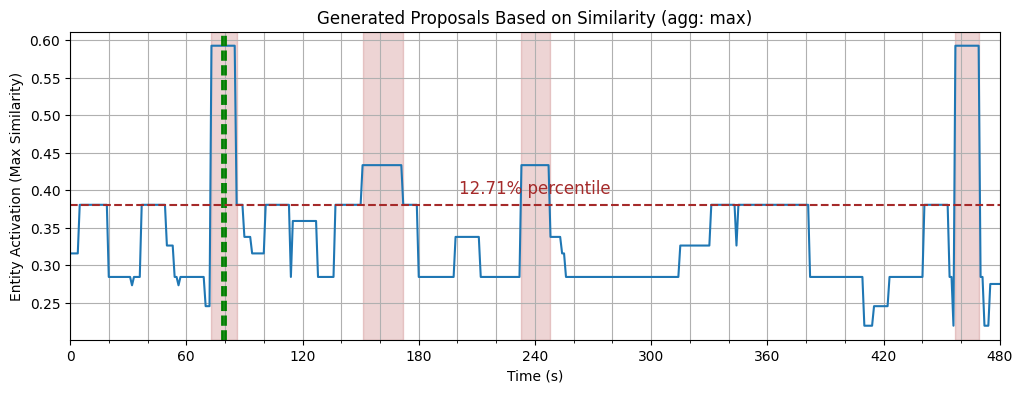

where was the drill machine?
457 469


,ents,sim,sim+,iv
0,box,0.06,0.01,"[(26.0, 28.0), (38.0, 40.0), (56.0, 58.0)]"
1,cable,0.22,0.02,"[(16.0, 22.0), (54.0, 56.0), (60.0, 62.0), (96..."
2,cable connector,0.27,0.03,"[(88.0, 90.0), (214.0, 216.0), (224.0, 226.0),..."
3,cable tie,0.25,0.03,"[(2.0, 4.0), (26.0, 38.0), (56.0, 58.0), (64.0..."
4,cable wire,0.27,0.03,"[(314.0, 316.0), (480.0, 480.0366739908854)]"
5,cables,0.18,0.02,"[(128.0, 134.0), (326.0, 328.0)]"
6,central processing unit,0.16,0.02,"[(48.0, 50.0)]"
7,circuit box,0.27,0.03,"[(22.0, 24.0)]"
8,circuit breaker,0.27,0.03,"[(40.0, 42.0)]"
9,drill bit,0.59,0.15,"[(78.0, 80.0), (462.0, 464.0)]"


In [24]:
import numpy as np
from matplotlib.ticker import MultipleLocator


def merge_intervals(ivs: list[tuple[int, int]], tol_sec=0., eps_sec=1e-3) -> list[tuple[int, int]]:
    ivs = sorted(ivs)
    merged = [ivs[0]]
    tol = tol_sec + eps_sec
    for (si, ei) in ivs[1:]:
        s, e = merged[-1]
        if si - tol <= e:
            merged[-1] = (s, max(ei, e))  # update e
        else:
            merged.append((si, ei))
    return merged

pd.set_option('display.max_columns', None)
sample = ds[1]
queries = [sample['query']]

print(sample['clip_uid'])
p_ner_json = Path(f'data/Ego4D-processed/captions/VideoRecap/caption_2s_uniner_outputs/{sample["clip_uid"]}.json')
print(p_ner_json)
ner_json = json.load(p_ner_json.open())
ents = [ner_cap['entities']['values'] for ner_cap in ner_json]
print(sum(map(len, ents)))
starts = [ner_cap['start'] for ner_cap in ner_json]
ends = [ner_cap['end'] for ner_cap in ner_json]
duration = max(ends)
df = pd.DataFrame({
    'ents': ents, 'start': starts, 'end': ends})
df_ = df.copy()
df = df.explode('ents')
df = df.dropna()
df['iv'] = df[['start', 'end']].apply(tuple, axis=1)
df_ner2iv = df.groupby(['ents'])['iv'].apply(list).reset_index()
df_ner2iv['iv'] = df_ner2iv['iv'].apply(lambda ivs: merge_intervals(ivs, tol_sec=2.))

# query-ner sim mapping with sbert or egovlp
ents = df_ner2iv['ents'].tolist()
prompt = '#C C picks '
tokens = tokenizer(
    [prompt + ent for ent in ents] + queries,
    return_tensors='pt', padding=True, truncation=True).to(device)
with torch.no_grad():
    z = lm.forward(tokens)
z = z['sentence_embedding'] if isinstance(z, dict) else z
z_ents, z_query = z[:-1], z[-1]
sim = z_ents @ z_query.T
sim = sim.detach().cpu()
df_ner2iv.insert(1, 'sim', sim.numpy())
df_ner2iv.insert(2, 'sim+', F.softmax(5*sim, dim=0).numpy())

s, e = sample['gt_start_sec'], sample['gt_end_sec']
df_iv2sim = df_ner2iv.explode('iv')[['iv', 'sim']]
df_iv2sim.insert(1, 's', df_iv2sim['iv'].apply(lambda iv: iv[0]))
df_iv2sim.insert(2, 'e', df_iv2sim['iv'].apply(lambda iv: iv[1]))
s_, e_ = df_iv2sim['s'].to_numpy(), df_iv2sim['e'].to_numpy()
t = np.arange(duration).astype(float)
eps_sec = 1e-3
tol_sec = 5.
y_ = df_iv2sim['sim'].to_numpy()[:, None] * (
    ((s_[:, None]-tol_sec-eps_sec) <= t[None, :]) & (t[None, :] <= (e_[:, None]+tol_sec+eps_sec))
)  # [#Entities, T]
y_ = y_.max(axis=0)  # [T,]
# thres = y_.max() * .8
thres = np.percentile(y_, 70)
proposals, = np.where(y_ > thres)
proposals = merge_intervals([
    (s, s+1) for s in proposals[:-1]] + [(proposals[-1]-1, proposals[-1])], tol_sec=0)
proposed_area = sum([e-s for s, e in proposals])
percentile_actual = proposed_area/duration
# intersection between proposals and gt
intersections = [
    (ss, ee) for s, e in proposals
    if (ss:=max(s, sample['gt_start_sec'])) < (ee:=min(e, sample['gt_end_sec']))]
iou = sum([e-s for s, e in intersections]) / proposed_area
iogt = sum([e-s for s, e in intersections]) / (sample['gt_end_sec'] - sample['gt_start_sec'])
print(f'IoU: {iou:.3f}, IoGT: {iogt:.3f}')
print(f'{proposed_area:.1f}s / {duration:.2f}s = {percentile_actual:.2%}')

# plotting
plt.figure(figsize=(12, 4))
plt.plot(t, y_)
b, t = plt.gca().get_ylim()
# plt.fill_between([s, e], b, t, color='g', alpha=.3)
plt.axvline(s, color='g', linestyle='--', lw=2)
plt.axvline(e, color='g', linestyle='--', lw=2)
for s, e in proposals:
    plt.fill_between([s, e], b, t, color='brown', alpha=.2)
plt.axhline(thres, color='brown', linestyle='--')
# plt.text(duration/2, thres*1.01, r'80% of max', color='brown', fontsize=12, ha='center')
plt.title('Generated Proposals Based on Similarity (agg: max)')
plt.text(duration/2, thres*1.04, fr'{percentile_actual:.2%} percentile', color='brown', fontsize=12, ha='center')
plt.ylim(b, t)
plt.xlim(0, duration)
plt.gca().xaxis.set_major_locator(MultipleLocator(60))
plt.gca().xaxis.set_minor_locator(MultipleLocator(20))
plt.xlabel('Time (s)')
plt.ylabel('Entity Activation (Max Similarity)')
plt.grid(which='both')
plt.show()

print(sample['query'])
print(s, e)
pd.set_option('display.float_format','{:.2f}'.format)
df_ner2iv

In [3]:
from tqdm.auto import tqdm
p_ner_jsons_dir = Path(f'data/Ego4D-processed/captions/VideoRecap/caption_2s_uniner_outputs')
PROMPT_ENTITY = '#C C picks '

def merge_intervals(ivs: list[tuple[int, int]], tol_sec=0., eps_sec=1e-3) -> list[tuple[int, int]]:
    ivs = sorted(ivs)
    merged = [ivs[0]]
    tol = tol_sec + eps_sec
    for (si, ei) in ivs[1:]:
        s, e = merged[-1]
        if si - tol <= e:
            merged[-1] = (s, max(ei, e))  # update e
        else:
            merged.append((si, ei))
    return merged

def evaluate_entity_proposals(sample, thres_percentile=70., aggregate_method='max', tol_sec=5., eps_sec=1e-3):
    queries = [sample['query']]
    p_ner_json = p_ner_jsons_dir / f'{sample["clip_uid"]}.json'
    ner_json = json.load(p_ner_json.open())
    ents = [ner_cap['entities']['values'] for ner_cap in ner_json]
    starts = [ner_cap['start'] for ner_cap in ner_json]
    ends = [ner_cap['end'] for ner_cap in ner_json]
    duration = max(ends)
    df = pd.DataFrame({'ents': ents, 'start': starts, 'end': ends})  # row = [list of ents, start, end]
    df = df.explode('ents')  # row = [ent, start, end]
    df = df.dropna()
    df['iv'] = df[['start', 'end']].apply(tuple, axis=1)
    df_ner2iv = df.groupby(['ents'])['iv'].apply(list).reset_index()
    df_ner2iv['iv'] = df_ner2iv['iv'].apply(lambda ivs: merge_intervals(ivs, tol_sec=2.))

    # query-ner sim mapping with sbert or egovlp
    ents = df_ner2iv['ents'].tolist()
    with torch.no_grad():
        tokens = tokenizer(
            [PROMPT_ENTITY + ent for ent in ents] + queries,
            return_tensors='pt', padding=True, truncation=True).to(device)
        z = lm.forward(tokens)
    z = z['sentence_embedding'] if isinstance(z, dict) else z
    z_ents, z_query = z[:-1], z[-1]
    sim = z_ents @ z_query.T
    sim = sim.detach().cpu()
    df_ner2iv.insert(1, 'sim', sim.numpy())

    s, e = sample['gt_start_sec'], sample['gt_end_sec']
    df_iv2sim = df_ner2iv.explode('iv')[['iv', 'sim']]  # row = [iv, sim]
    df_iv2sim.insert(1, 's', df_iv2sim['iv'].apply(lambda iv: iv[0]))
    df_iv2sim.insert(2, 'e', df_iv2sim['iv'].apply(lambda iv: iv[1]))
    s_, e_ = df_iv2sim['s'].to_numpy(), df_iv2sim['e'].to_numpy()
    t = np.arange(duration).astype(float)
    y_ = df_iv2sim['sim'].to_numpy()[:, None] * (
        ((s_[:, None]-tol_sec-eps_sec) <= t[None, :]) & (t[None, :] <= (e_[:, None]+tol_sec+eps_sec))
    )  # [#Entities, T]
    y_ = {'max': y_.max, 'mean': y_.mean, 'sum': y_.sum}[aggregate_method](axis=0)  # [T,]
    thres = np.percentile(y_, thres_percentile)
    proposals, = np.where(y_ > thres)
    if len(proposals) == 0:
        return {
            'iou': 0., 'iogt': 0.,
            'proposed_area': 0., 'duration': duration,
            'percentile_actual': 0.,
            'y_': y_, 'thres': thres, 'proposals': proposals,
        }
    proposals = merge_intervals([
        (s, s+1) for s in proposals[:-1]] + [(proposals[-1]-1, proposals[-1])], tol_sec=0)
    proposed_area = sum([e-s for s, e in proposals])
    percentile_actual = proposed_area/duration
    # intersection between proposals and gt
    intersections = [
        (ss, ee) for s_, e_ in proposals
        if (ss:=max(s_, s)) < (ee:=min(e_, e))]
    iou = sum([e-s for s, e in intersections]) / proposed_area
    iogt = sum([e-s for s, e in intersections]) / (e - s)
    # return iou, iogt, proposed_area, duration, percentile_actual
    return {
        'iou': iou, 'iogt': iogt,
        'proposed_area': proposed_area, 'duration': duration,
        'percentile_actual': percentile_actual,
        'y_': y_, 'thres': thres, 'proposals': proposals,
    }

records = []
for i in tqdm(range(len(ds))):
    sample = ds[i]
    record = evaluate_entity_proposals(sample)
    records.append(record)
records = pd.DataFrame(records)
records

  0%|          | 0/4539 [00:00<?, ?it/s]

/tmp/ipykernel_1460135/3514774764.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403463728/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  sim = z_ents @ z_query.T


ValueError: zero-size array to reduction operation maximum which has no identity

In [17]:
sample.keys()

dict_keys(['clip_uid', 'video_uid', 'duration', 'query', 'ctx_ts', 'hist', 'captions', 'gt_start_sec', 'gt_end_sec', 'gt_segment'])

In [9]:
%cd /data/gunsbrother/prjs/ltvu/ours
import re
import pandas as pd
from pathlib import Path
iogt_threses = [.3, .5]
records = []
pattern = re.compile(r'w(\d{2}\.\d)_k(\d+)')
# for p_csv in Path('results').glob('records-*.csv'):
for p_csv in Path('results/without_rgb/mips').glob('w*.csv'):
    # _, thresp, agg, tol = p_csv.stem.split('-')
    thresp, k = pattern.findall(p_csv.stem)[0]
    df = pd.read_csv(p_csv)
    # record_base = {'thresp': float(thresp[-2:]), 'agg': agg, 'tol': float(tol[3:-1])}
    record_base = {'thresp': float(thresp)}
    for thres in iogt_threses:
        records.append(record_base | {
            'iogt_thres': thres,
            'iogt_recall': (df['iogt'] >= thres).mean(),
            'miou': df['iou'].mean(),
            'miogt': df['iogt'].mean(), 'proposal_portion': df['proposal_portion'].mean()})
records = pd.DataFrame(records).sort_values(by=['thresp'])
records

/data/gunsbrother/prjs/ltvu/ours


,thresp,iogt_thres,iogt_recall,miou,miogt,proposal_portion
0,10.0,0.3,0.332452,0.064424,0.295564,0.087004
1,10.0,0.5,0.293457,0.064424,0.295564,0.087004
6,30.0,0.3,0.483587,0.048358,0.460139,0.213543
7,30.0,0.5,0.461335,0.048358,0.460139,0.213543
4,60.0,0.3,0.602776,0.039490,0.587096,0.355397
5,60.0,0.5,0.589998,0.039490,0.587096,0.355397
2,90.0,0.3,0.677462,0.034954,0.667357,0.464335
3,90.0,0.5,0.669751,0.034954,0.667357,0.464335


In [14]:
from copydf import copyDF
pd.set_option('display.precision', 2)
d_ = 100*records.groupby(['thresp', 'agg', 'iogt_thres']).agg({'iogt_recall': 'max', 'miogt': 'max'}).round(4).unstack()
copyDF(d_)
d_

<IPython.core.display.Javascript object>

iogt_recall         miogt       
iogt_thres          0.3    0.5    0.3    0.5
thresp agg                                  
60.0   max        53.49  50.08  49.67  49.67
       mean       61.93  56.55  55.83  55.83
       sum        62.04  56.62  55.97  55.97
70.0   max        45.80  42.59  42.35  42.35
       mean       52.96  47.43  47.12  47.12
       sum        53.12  47.90  47.47  47.47
80.0   max        34.15  31.61  31.42  31.42
       mean       41.99  35.98  36.31  36.31
       sum        42.59  36.29  36.71  36.71

In [29]:
records[records['iogt_thres']<.5][['thresp', 'agg', 'iogt_recall']].pivot_table(index='thresp', columns='agg', values='iogt_recall').round(4)

agg,max,mean,sum
thresp,,,
60.00,0.51,0.60,0.60
70.00,0.42,0.51,0.51
80.00,0.30,0.40,0.40


In [ ]:
# plotting
plt.figure(figsize=(12, 4))
plt.plot(t, y_)
b, t = plt.gca().get_ylim()
# plt.fill_between([s, e], b, t, color='g', alpha=.3)
plt.axvline(s, color='g', linestyle='--', lw=2)
plt.axvline(e, color='g', linestyle='--', lw=2)
for s, e in proposals:
    plt.fill_between([s, e], b, t, color='brown', alpha=.2)
plt.axhline(thres, color='brown', linestyle='--')
# plt.text(duration/2, thres*1.01, r'80% of max', color='brown', fontsize=12, ha='center')
plt.text(duration/2, thres*1.04, fr'{percentile_actual:.2%} percentile', color='brown', fontsize=12, ha='center')
plt.ylim(b, t)
plt.xlim(0, duration)
plt.gca().xaxis.set_major_locator(MultipleLocator(60))
plt.gca().xaxis.set_minor_locator(MultipleLocator(20))
plt.xlabel('Time (s)')
plt.ylabel('Entity Activation (Max Similarity)')
plt.grid(which='both')
plt.show()

print(p_ner_json)
print(sample['clip_uid'])
print(sample['query'])
print(s, e)
df_iv2sim